# An Example in Constraint Optimization

## Introduction

The task is to manage energy consumption for a local site, for example a neighborhood of households or an industrial area. The *predicted* gas consumption for the next 72 hours (3 days) is given in the following vector, say in cubic meters or similar.

In [1]:
T <- 1:72
P <- c( 96.6, 96, 98.4, 99.1, 98, 100.6, 100.7, 99.4, 99.5, 98.9, 98, 98.3, 96.3, 
        98.4, 95.5, 95.3, 95.8, 94.6, 94.4, 93.8, 95.2, 94, 96.6, 98.2, 96.7, 99.2, 
        100.6, 98.6, 99.4, 102, 101.3, 102.5, 102.5, 102.1, 102.2, 100.9, 100.8, 
        97.6, 98.1, 97.4, 95.4, 96.9, 95.3, 97.7, 95.5, 97, 96.9, 96, 95.3, 98, 
        97.6, 99.7, 99.9, 101.2, 100, 98.6, 99.2, 97.4, 97.7, 97.1, 96.5, 95.5, 
        96.4, 93, 95, 95.4, 95.3, 95.4, 95.3, 96.4, 96.9, 96.7)

The following plot displays this prediction as a step curve. The local supplier of energy buys gas from a global supplier. The contract says he will get up to 100 [m^3] per hour to a fixed price, if more gas is consumed the price will go up significantly. The red line marks this upper limit.


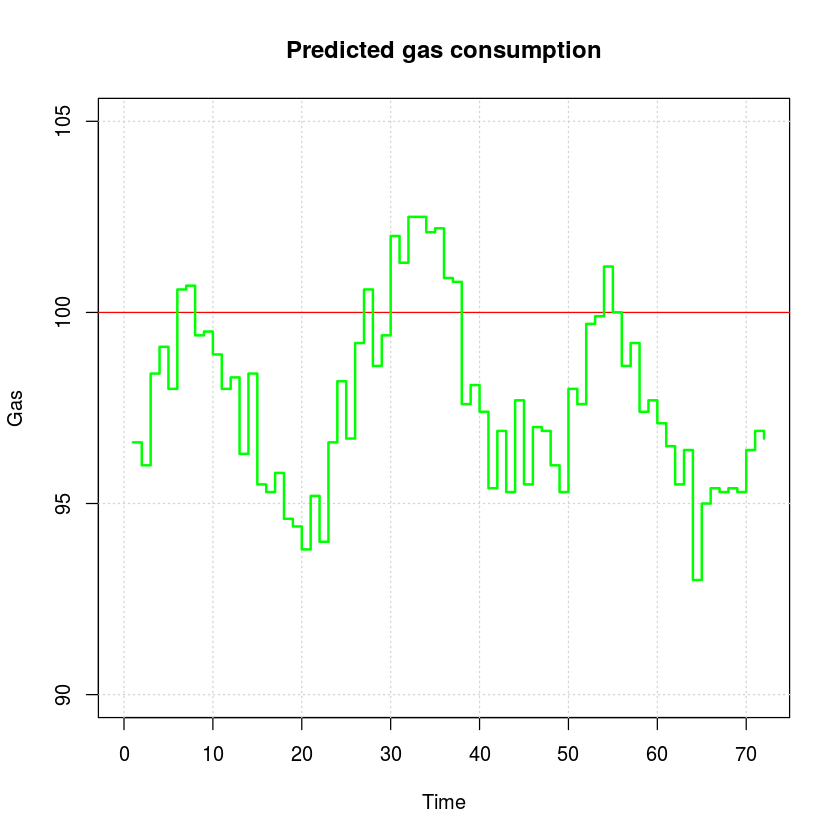

In [2]:
plot(c(0, 72), c(90, 105), type = "n",
    main = "Predicted gas consumption", xlab = "Time", ylab = "Gas")
grid(); abline(h = 100, col = "red")
lines(T, P, col = "green", type = "s", lwd = 2)

To avoid these extra costs the local provider will employ some kind of gas storage, e.g. a gas tank (or the so-called "net aspiration"). When gas consumption in the area is low, the tank can be filled, and when consumption is greater than 100 the gas storage will be used to contribute the missing amount.

Of course, the gas storage facility has some technical constraints that need to be taken into account. The maximum amount of gas to be stored in the tank shall be 10 [m^3], so the actual amount of gas in the tank will vary between 0 and 10. Also, the amount of gas that will be pumped in or taken out has be less or equal to 5 [m^3] per hour.

Imagine the *planned* amount of gas bought from the global supplier is 

In [3]:
P0 <- c(
100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0,  99.2,  98.0,  98.3,
 96.3,  98.4,  95.5,  95.3,  95.8,  94.6,  94.4,  93.8,  95.2,  94.0,  96.6,  98.2,
 96.7,  99.2, 100.0,  99.2,  99.4, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0,
100.0, 100.0, 100.0, 100.0, 100.0,  99.7,  95.3,  97.7,  95.5,  97.0,  96.9,  96.0,
 95.3,  98.0,  97.6,  99.7,  99.9, 100.0, 100.0,  99.8,  99.2,  97.4,  97.7,  97.1,
 96.5,  95.5,  96.4,  93.0,  95.0,  95.4,  95.3,  95.4,  95.3,  96.4,  96.9,  96.7)


then the combined display of predicted and planned gas consumption is shown in the following plot:

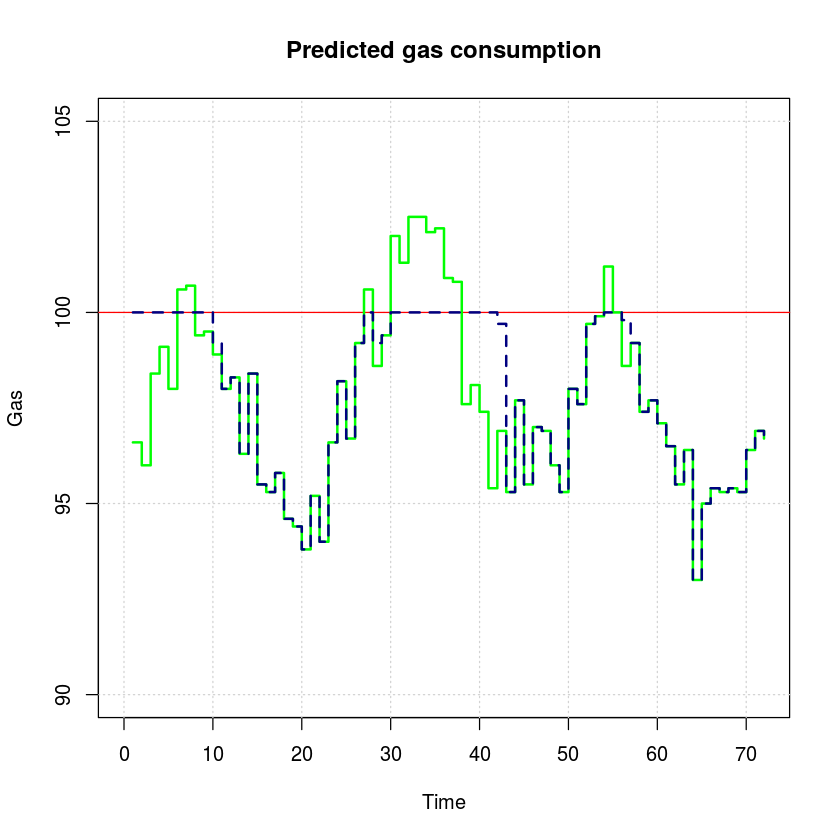

In [4]:
plot(c(0, 72), c(90, 105), type = "n",
    main = "Predicted gas consumption", xlab = "Time", ylab = "Gas")
grid(); abline(h = 100, col = "red")
lines(T, P, col = "green", type = "s", lwd = 2)
lines(T, P0, col = "navy", type = "s", lwd = 2, lty = 2)

Can this plan be satisfied by utilizing the gas storage available to the local supplier? Assuming the gas tank is half-filled with 5 [m^3], what will be the level in the tank during the planned 72 hours? Obviously, the filling level is calculated as `5 + cumsum(P0 - P)`. So with this planning the tank level varies as follows:

In [5]:
T0 <- 3 + cumsum(P0 - P)

From now on we will plot the (predicted or planned) gas consumption and the level in the gas tank -- i.e. the volume of stored gas -- side by side in one graph. For this *greedy* approach the figure looks as follows:

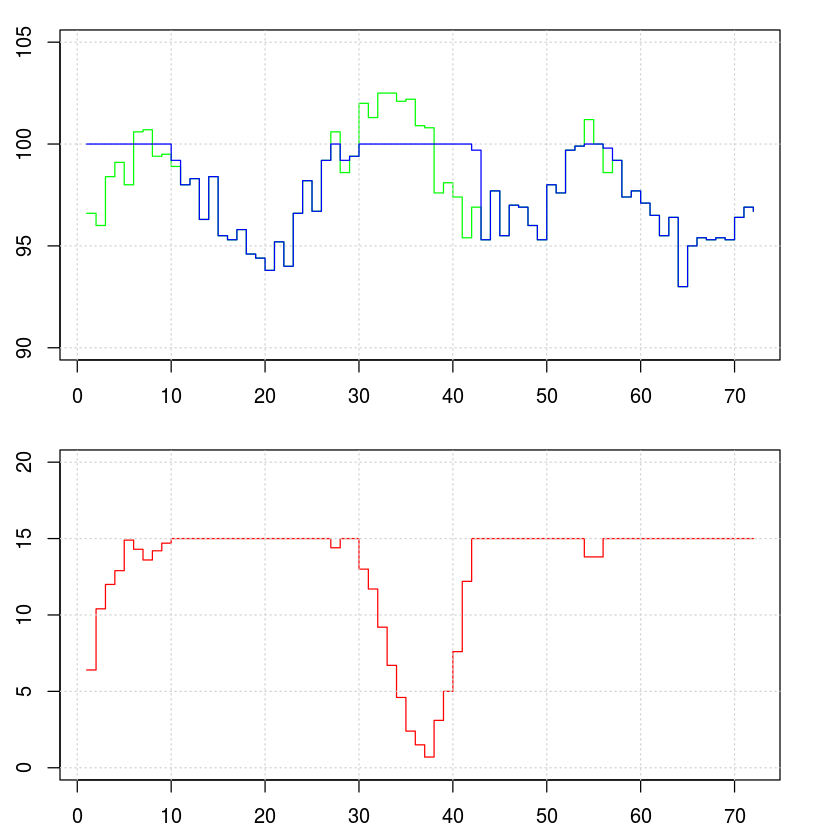

In [6]:
plot_gas_solution <- function(T, P, P0, T0) {
    par(mfrow = c(2, 1), ann = FALSE, mai = c(0.5, 0.5, 0.25, 0.5))
    plot(T, P, type = "s", col = "green", ylim = c(90, 105)); grid()
    lines(T, P0, type = "s", col = "blue")
    plot(T, T0, type = "s", col = "red", ylim = c(0, 20)); grid()
}

plot_gas_solution(T, P, P0, T0)

We see that the gas tank is completely filled most of the time and that it can handle the problem of a missing gas volume during the 30--40 hours ahead.

## Problem Formulation

The task now is to formulate this as an optimization problem such that, when given a prediction of gas consumption for 72 hours, a purchase plan for buying gas from the global provider will be generated. The plan shall make it possible to never buy more than a certain amount of gas, and the gas tank shall be used in a moderate way.

#### Decision Variables

Let $n$ be the number of time periods, $p_i, i=1, ...,72$ be the predicted consumption values, and $q_i$ the unknown planning values to be optimized during the optimization procedure. 

How can a feasible starting point `x0` be found? The same way `P0` above was found. That is, immediately fill up the tank and keep it filled as much as possible. If this leads to a non-feasible solution -- because the storage tank is not big enough -- than we know that the whole optimization problem is not solvable. It is a very nice feature of this optimization problem that feasibility can so easily be determined, and if applicable a feasible starting point is constructed.

#### Constraints

The following constants need to be defined:

  - $n$, the number of predicted resp. planned time periods.

  - $d_0$: initial level of the gas tank.

  - $d_1$: maximum level change per time unit.

  - $d_2$: maximum level of gas tank (minimum is 0).

  - $d_3$: maximum allowed amount of gas from the global supplier.

In [7]:
n <- 72
d0 <- 3
d1 <- 5
d2 <- 15
d3 <- 100

With these values the constraints are defined as

  1. maximum supply to be ordered from the global supplier:  
     $$ q_i \leq d_3 \qquad \mathrm{for\ all} \; i = 1 \ldots n $$

  1. restricted amount to be taken from or filled into gas tank:
     $$ |q_i - p_i| \le d_1 \qquad \mathrm{for\ all} \; i = 1 \ldots n$$

  1. level in storage tank restricted by capacity:
     $$ 0 \le d_0 + \sum_{k=1}^{j} (q_k - p_k) \leq d_2  \qquad \mathrm{for\ all} \; j = 1 \ldots n$$

#### Objective

The objective function will describe the overall goal that is to be reached.  
Four different goals will be considered and compared:

  - (**A**) Minimize the sum of differences between predicted and planned purchase of gas from the global supplier:
    $$ \min ! \sum_{j=1}^n |p_j - q_j| $$

  - (**B**) Minimize the sum of squares of these differences:
    $$ \min ! \sum_{j=1}^n (p_j - q_j)^2 $$
    (Larger differences will have a larger influence on the objective.)

  - (**C**) Minimize the difference between subsequent supplies:
    $$ \min ! \sum_{j=1}^{n-1} |q_{j+1} - q_{j}| $$

  - (**D**) Minimize usage of the gas tank as much as possible:
    $$ \min ! \sum_{k=1}^{n} | \sum_{j=1}^{k} (p_j - q_j)|$$

We will see that very different solutions will be returned with each of these objectives. Of course, it is up to the customer of such an optimization package to decide which solution and thus which objective function he prefers.


The objective functions will be the same for all solvers, so we will define them here.

In [8]:
funA <- function(q) sum(abs(P - q))

funB <- function(q) sum((P - q)^2)

funC <- function(q) sum(abs(diff(q)))

funD <- function(q) sum(abs(cumsum(P - q)))

## Nonlinear Optimization Solvers in R

The function `constrOptim()` in base R is a solver for nonlinear optimization problems with *linear* constraints. It implements an adaptive logarithmic barrier algorithm, using `optim()` as the underlying solver. Its usage is as follows:

```r
    constrOptim(theta, f, grad, ui, ci, mu = 1e-04, control = list(),  
                method = if (is.null(grad)) "Nelder-Mead" else "BFGS", 
                outer.iterations = 100, outer.eps = 1e-05, ..., hessian = FALSE)
```

But our constraints are nonlinear, so we need a more powerful tool. The appropriate technique here is the *augmented Lagrangian*. Solvers available in R packages that apply this approach are

  - nloptr
  - alabama
  - Rsolnp
  - Rdonlp2

Unfortunately, different optimization solvers will require to receive the the constraints and objective function in different ways. The following solvers for non-linear constraint optimization will be tried on the problem: 'alabama', 'nloptr'.

Because all these solvers are *local* solvers, i.e. will stop in local minima, we will also try a global (or stochastic) solver and compare it with solutions found with local solvers.

### The *alabama* package

Solver `auglag()` in package 'alabama' optimizes smooth nonlinear objective functions with nonlinear constraints. Equality and inequality constraints are allowed. As the problem formulated above does not involve equality constraints, the full power of an augmented Lagrangian approach is not required.

The general call to `auglag()` looks like this:

```r
auglag(par, fn, gr, hin, hin.jac, heq, heq.jac, 
       control.outer=list(), control.optim = list(), ...)
```

with the following parameters

Argument  | Meaning
--------- | ----------------------------------------------
`par`     | initial vector of variable values  
`fn`      | nonlinear objective function
`gr`      | gradient of the objective function
`hin`     | function specifying the inequality constraints
...       | ...

And `control.optim` a list of control parameters, the same as those used in `optim()`. The default method is "BFGS". At the moment we rely on numerical gradients and jacobians. For more information see `?auglag`.

In [9]:
require(alabama)
# ?auglag

Loading required package: alabama
Loading required package: numDeriv


The constraint inequalities need to be defined through `hin[j] >= 0` for all `j`. Therefore, we define function `hin()` as

In [10]:
hin <- function(q) {
    c(d3 - q,                   # q[i] <= d3
      d1 - abs(P - q),          # abs(P - q) <= d1
      d0 + cumsum(q - P),       # 0 <= d0 + cumsum(q - P)
      d2 - d0 - cumsum(q - P)   # d0 + cumsum(q - P) <= d2
    )
}

#### Objective `funA`

In [11]:
solA1 <- auglag(par = P0, fn = funA, hin = hin, control.outer = list(trace = FALSE))
xA1 <- solA1$par
solA1$value

[1] 31.8

Display the solution and the level in the storage tank.

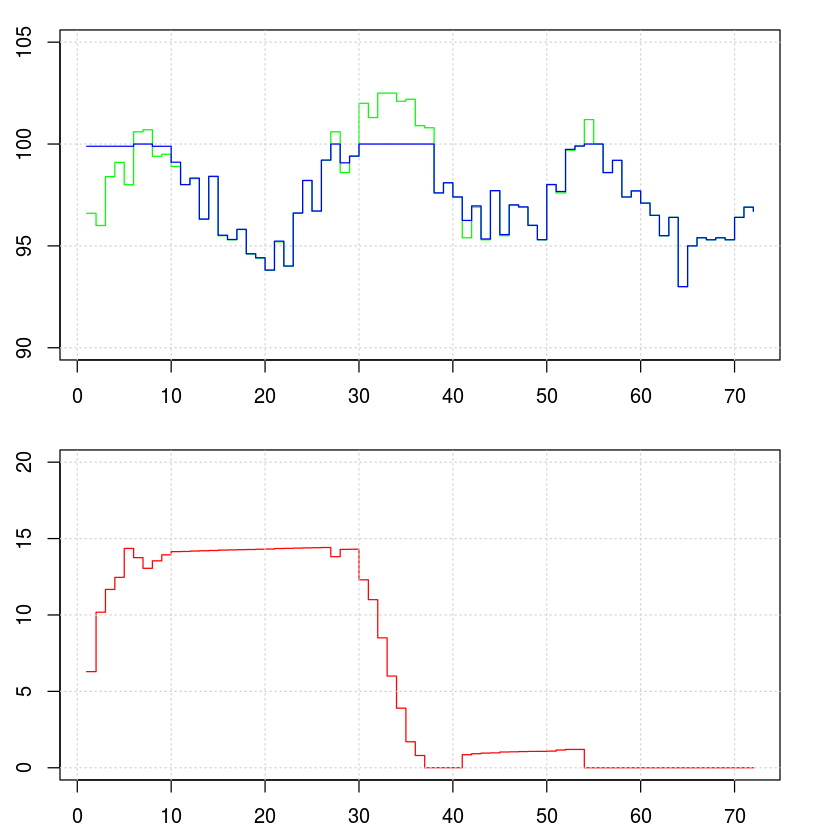

In [12]:
P1 <- solA1$par; T1 <- 3 + cumsum(P1 - P)
plot_gas_solution(T, P, P1, T1)

In this solution, the level in the gas tank is kept at a minimum and only raised when it is absolutely necessary to provide for peaks in the predicted consumtion. Compare this with a solution to problem (B).

#### Objective `funB`

In [13]:
require(alabama)
solB1 <- auglag(par = P0, fn = funB, hin = hin, control.outer = list(trace = FALSE))
xB1 <- solB1$par
solB1$value

[1] 38.3316

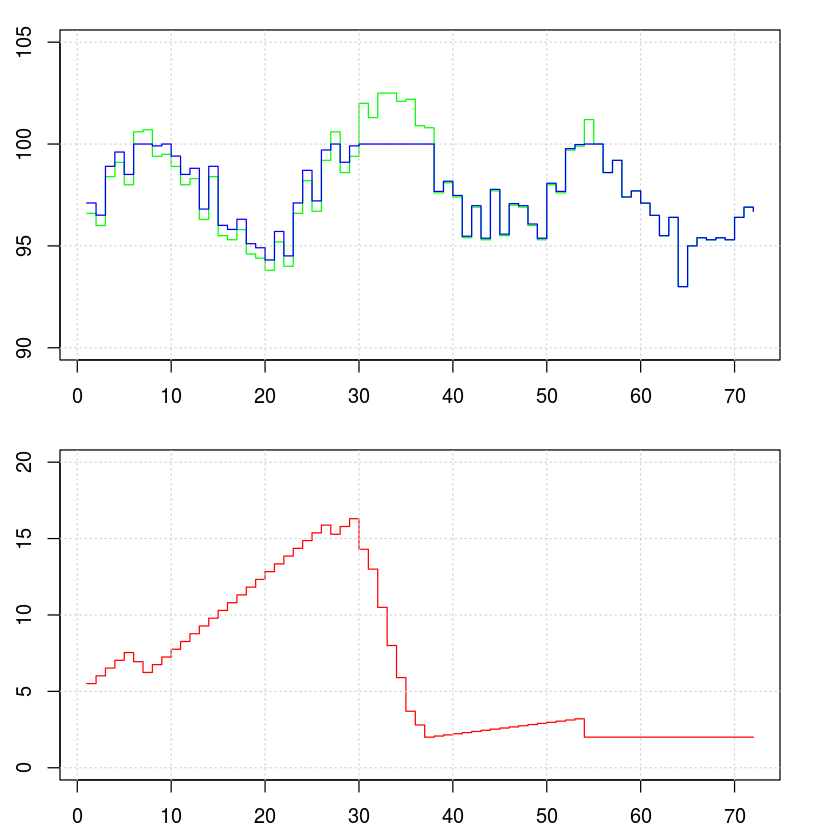

In [14]:
P2 <- solB1$par; T2 <- 5 + cumsum(P2 - P)
plot_gas_solution(T, P, P2, T2)

In this solution, the level in the gas tank is only raised slowly and only when it is absolutely necessary to provide for peaks in the predicted consumption.

#### Objective `funC`

For problem type (C) it is the goal to minimize the differences between gas intakes from the global supplier.

In [15]:
require(alabama)
solC1 <- auglag(par = P0, fn = funC, hin = hin, control.outer = list(trace = FALSE))
xC1 <- solC1$par
solC1$value

[1] 8.138929

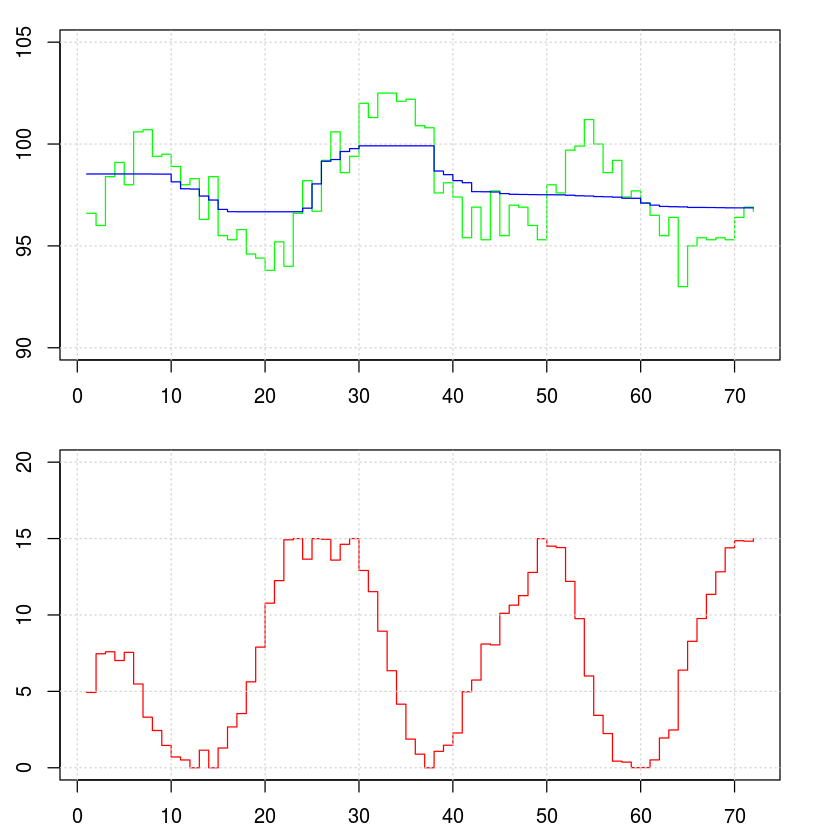

In [16]:
P3 <- solC1$par; T3 <- 3 + cumsum(P3 - P)
plot_gas_solution(T, P, P3, T3)

In this case the level in the gas tank varies quite much.

#### Objective `funD`

For problem type (D) it is the goal to minimize the usage of the gas tank as much as possible.

In [17]:
require(alabama)
solD1 <- auglag(par = P0, fn = funD, hin = hin, control.outer = list(trace = FALSE))
xD1 <- solD1$par
solD1$value

[1] 98.20184

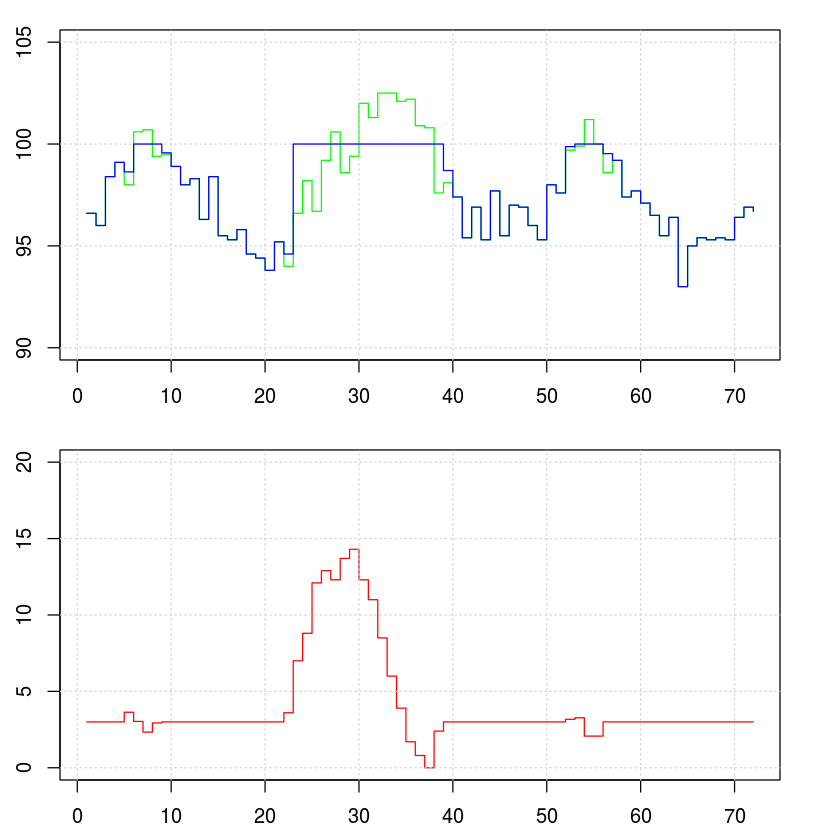

In [18]:
P4 <- solD1$par; T4 <- 3 + cumsum(P4 - P)
plot_gas_solution(T, P, P4, T4)

Interestingly, in this case the level in the gas tank is kept to the level it had at the start, is raised if there is a need ahead, and then kept constant at the initial value.

### The *nloptr* package

In [19]:
require(nloptr)
# ?nloptr::auglag

Loading required package: nloptr

Attaching package: ‘nloptr’

The following object is masked from ‘package:alabama’:

    auglag



In [20]:
( sol <- nloptr::auglag(x0 = P0, fn = funD, hin = hin, localsolver = "LBFGS") )

$par
 [1]  96.59891  96.00111  98.40056  99.09944  98.64571  99.99997  99.99897
 [8]  99.99999  99.55839  98.89723  98.00090  98.29613  96.30283  98.39945
[15]  95.49869  95.30213  95.80311  94.59457  94.38264  93.81713  95.55549
[22]  95.17706  99.07087  99.99938  99.99959  99.99990  99.99990 100.00000
[29] 100.00000 100.00000 100.00000 100.00000 100.00000 100.00000 100.00000
[36] 100.00000 100.00000  99.99953  98.69985  97.40037  95.40090  97.09476
[43]  95.10322  97.70231  95.49867  96.99851  96.90385  95.99812  95.30137
[50]  97.99835  97.60004  99.99064  99.99993  99.99993  99.99998  99.40963
[57]  99.19929  97.40091  97.70040  97.09943  96.50014  95.50244  96.39754
[64]  92.99882  95.00147  95.39860  95.29971  95.40166  95.30090  96.39856
[71]  96.90107  96.69908

$value
[1] 99.74365

$iter
[1] 729

$global_solver
[1] "NLOPT_LD_AUGLAG"

$local_solver
[1] "NLOPT_LD_LBFGS"

$convergence
[1] 4

$message
[1] "NLOPT_XTOL_REACHED: Optimization stopped because xtol_rel or xtol_abs (above) was reached."

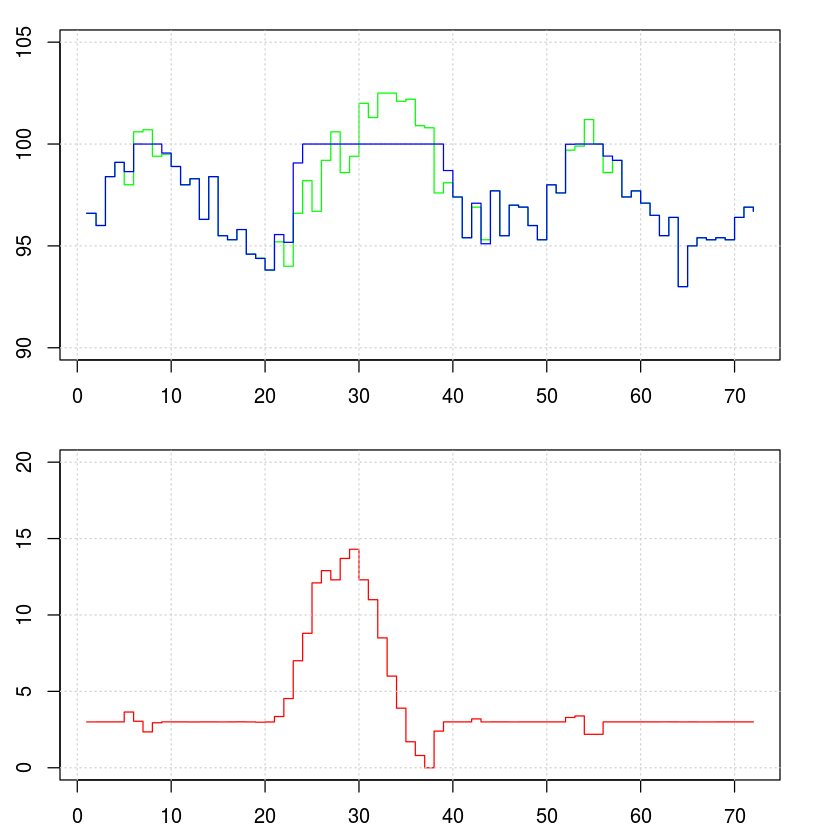

In [21]:
P5 <- sol$par; T5 <- 3 + cumsum(P5 - P)
plot_gas_solution(T, P, P5, T5)

This agrees quite exactly with the solution found by `alabama::auglag` !

## Some Remarks

### Global Solvers

There are several global (or: stochastic) solvers in R packages that try to avoid falling into or getting stuck in local minima. There is absolutely no guaranty they will find the global minimum. The problem here with 72 dimensions may anyway be to demanding.

For realizing constraints for application in global solvers the objective function has to be changed to include the constraints.

In [22]:
funDconstr <- function(q) {
    if (# any(q > d3) ||
        any(abs(P - q) > d1 + 0.001) ||
        any(d0 + cumsum(q - P) < -0.001) || 
        any(d0 + cumsum(q - P) > d2 + 0.001) ){
        v <- Inf
    } else {
        v <- sum(abs(cumsum(P - q)))
    }
    v
}

In [23]:
require(DEoptim)
# ?DEoptim

Loading required package: DEoptim

DEoptim package
Differential Evolution algorithm in R
Authors: D. Ardia, K. Mullen, B. Peterson and J. Ulrich



In [24]:
sol <- DEoptim(funDconstr, lower = rep(0, 72), upper = rep(100, 72),
                control=DEoptim.control(trace = FALSE))
sol$optim

$bestmem
      par1       par2       par3       par4       par5       par6       par7 
13.0816069 37.7001394 58.0040045 16.1892403 59.4149709 38.4608807 46.5962492 
      par8       par9      par10      par11      par12      par13      par14 
78.7978069 38.4119799 72.4666443 92.4671353 37.0134336 80.5997581 84.7988850 
     par15      par16      par17      par18      par19      par20      par21 
36.2438438 75.8663428 47.8722648 37.7616989 40.7056775 60.5002469 14.2377811 
     par22      par23      par24      par25      par26      par27      par28 
22.0176759 30.7340047 36.8046017 37.8502324 85.9464910 61.7429657 81.8412055 
     par29      par30      par31      par32      par33      par34      par35 
57.7491433 49.7165984 20.1104662 29.1323970 72.1030247 13.3235943 58.1106221 
     par36      par37      par38      par39      par40      par41      par42 
54.9491913 66.3247102 80.9321392 61.9171396 53.3641762 70.7569821 18.6819009 
     par43      par44      par45      par46      par47      par48      par49 
39.8277879 74.5165302 48.2873673 50.7920338 49.7583681 78.4112194 72.5511527 
     par50      par51      par52      par53      par54      par55      par56 
 4.2610012 16.7142282 19.2892339  0.2287101 60.4324849 92.1863872 44.0147381 
     par57      par58      par59      par60      par61      par62      par63 
97.0953422 82.3845442 67.2124875 99.3674361 85.4644239 88.6985497 49.2805519 
     par64      par65      par66      par67      par68      par69      par70 
62.1778574 55.3358705 58.4999817 45.6047700 45.6557462 12.9174374 66.2025419 
     par71      par72 
73.6915600 89.7816473 

$bestval
[1] Inf

$nfeval
[1] 402

$iter
[1] 200

We can see that global solvers will have severe problems with constraints if the feasible points are rare in the solution space, or if the best solutions lie on or near the boundary.

### MATLAB Solution

In MATLAB, the standard solver for constrained nonlinear optimization (i.e., 'nonlinear programming') is `fmincon` from the *Optimization Tolbox*. It incorporates **active-set**, **sqp**, **trust-region**, and **interior-point** algorithms.

The solver `fmincon` is called with the following syntax and parameters:

    fmincon(fun,x0,A,b,Aeq,beq,lb,ub,nonlcon)

where `obj` is the objective function, `x0` the starting point, `A*x <= b` the linear inequality and `Aeq*x = beq` the linear equality constraints, `lb` and `ub` the lower and upper bounds with `lb <= x <= ub`.  
`nonlcon` defines the nonlinear equality and inequality constraints `c(x) <= 0` and `ceq(x) = 0` by returning two vectors `c` and `ceq`: `[c,ceq] = nonlcon(x)`.

The user interface for a demo system to discuss with engineers and customers was developed utilizing MATLAB's GUI editor and is shown in the following figure.

![MATLAB solution](matlab.png)

One can see in this figure that `fmincon` finds the same solutions as `auglag` in R above.

A point to clarify will be what happens when we start with other feasible points.

### Modeling Language

R and MATLAB do not have *optimization modeling languages* that would enable the user to formulate optimization problems independently of what the API of different solvers will require. Commercial programs such as AMPL, GAMS, or Gurobi each have their own (algebraic) modeling languages. Goals for applying a modeling language are, e.g., user friendliness, mathematical notation, solver independence, and getting access to advanced optimization techniques.

The following is an AMPL model for our minimization problem with target function `funB`, but extended with a request that the gas tank should be filled up to a level of 5.

**AMPL Model**

    param n > 0 integer;    # n = 72 time units
    param p  {i in 1..n};   # predicted consumption

    param d0;   # initial gas tank storage
    param d1;   # max level change per time unit
    param d2;   # max level of gas tank
    param d3;   # max amount of gas from supplier

    var x {i in 1..n} >= 0; # solution

    minimize target:
        sum {j in 1..n} (p[j] - x[j]) * (p[j] - x[j]);

    subject to rule1 {i in 1..n}: x[i] <= d3;
    subject to rule2 {i in 1..n}: abs(x[i] - p[i]) <= d1;
    subject to rule3 {j in 1..n}:
        sum {k in 1..j} (x[k] - p[k]) <= d2 - d0;
    subject to rule4 {j in 1..n}:
        sum {k in 1..j} (x[k] - p[k]) >= -d0;

**AMPL Data**

    param n := 72;

    param d0 := 3;
    param d1 := 5;
    param d2 := 15;
    param d3 := 100;

    param: p :=
        1  96.6  2  96.0 ... 72  96.7;

**AMPL Commands**

    ampl: option solver minos;
    ampl: option minos_options 'iterations_limit=5000 superbasics_limit=100';

    ampl: model gas_ex.mod;
    ampl: data gas_ex.dat;

    ampl: solve;
    ampl: display x;

Sending this to AMPL will call the MINOS solver on the model and data and will result in the following output:

    MINOS 5.51: iterations_limit=5000
    superbasics_limit=100
    MINOS 5.51: optimal solution found.
    237 iterations, objective 38.3316
    Nonlin evals: obj = 352, grad = 351, constrs = 352, Jac = 351.

    x [*] :=
     1  97.108   13  96.808   25  97.208   37 100       49  95.375   61  96.5
     2  96.508   14  98.908   26  99.708   38  97.675   50  98.075   62  95.5
     3  98.908   15  96.008   27 100       39  98.175   51  97.675   63  96.4
     4  99.608   16  95.808   28  99.108   40  97.475   52  99.775   64  93
     5  98.508   17  96.308   29  99.908   41  95.475   53  99.975   65  95
     6 100       18  95.108   30 100       42  96.975   54 100       66  95.4
     7 100       19  94.908   31 100       43  95.375   55 100       67  95.3
     8  99.908   20  94.308   32 100       44  97.775   56  98.6     68  95.4
     9 100       21  95.708   33 100       45  95.575   57  99.2     69  95.3
    10  99.408   22  94.508   34 100       46  97.075   58  97.4     70  96.4
    11  98.508   23  97.108   35 100       47  96.975   59  97.7     71  96.9
    12  98.808   24  98.708   36 100       48  96.075   60  97.1     72  96.7
    ;

This corresponds to the solution `P2` that we found above.

### *rneos*: XML-RPC Interface to NEOS

> "Within this package the XML-RPC API to NEOS is implemented. This enables the 
> user to pass optimization problems to NEOS and retrieve results within R."

The NEOS Server is an internet-based service for solving numerical optimization problems. It provides free access to more than 60 state-of-the-art (commercial and non-commercial) solvers. Optimization problems need to be formulated in AMPL or GAMS syntax. Results will be returned as Web pages.

With the above model and data as files *gas_ex.mod* and *gas_ex.dat*, an interaction with the CONOPT solver on NEOS would look like:

```r
require(rneos)
# geting a template for category and solver
temple <-NgetSolverTemplate(category = "nco", solvername = "CONOPT",
                            inputMethod = "AMPL")
# setting model and data file
modf <- "gas_ex.mod"; datf <- "gas_ex.dat"
modc <- paste(paste(readLines(modf), collapse = "\n"), "\n")
datc <- paste(paste(readLines(datf), collapse = "\n"), "\n")

# create list object
argslist <- list(model = modc, data = datc,
                 commands = "", comments = "Gas example")
## create XML string
xmlstring <- CreateXmlString(neosxml = temple, cdatalist = argslist)

## submit job to the NEOS solver
neosjob <- NsubmitJob(xmlstring, user = "hwb", interface = "gas_ex",
                      id = 8237, nc = CreateNeosComm())
neosjob
# The job number is: 3838832 
# The pass word is : wBgHomLT 

# getting info about job
NgetJobInfo(neosjob)            # "nco"   "MINOS" "AMPL"  "Done" 
NgetFinalResults(neosjob)
```

The available NEOS solvers and the required modeling language(s) can be found on the following NEOS solvers page [**http://www.neos-server.org/neos/solvers/**](NEOS Solvers.html) at the University of Wisconsin *Institutes for Discovery*.